Importing required libraries and modules

In [37]:
import jax
import numpy as np
import jax.numpy as jnp

from jax import make_jaxpr
from jax import grad, value_and_grad

import matplotlib.pyplot as plt

Defining a linear function and passing values to obtain returned value

In [38]:
def linear_func(x, w, b):
    y = w * x + b
    return y

In [39]:
x = 4.0
w = 3.0
b = 2.0

linear_func(x, w, b)

14.0

The `grad` function in JAX is used for computing the gradients. As we know that the basic idea behind JAX is to work with function compositions,`grad` also takes a callable as input and returns a callable. So, whenever we want to do the computation of the gradients, we need to pass a callable to `grad` first. Let's take an example to make it more clear

The grad() function can let us find out the differentiation of function with respect to a parameter which accepts python list, dictionary, and tuple as well . It'll differentiate input function with respect to all jax arrays given through python list, dict, or tuple.

In [29]:
dx = grad(linear_func)(x, w, b)

dx

DeviceArray(3., dtype=float32, weak_type=True)

In [30]:
dw = grad(linear_func, argnums = 1)(x, w, b)

dw

DeviceArray(4., dtype=float32, weak_type=True)

As we can combine function transforms in JAX, we can make `jaxprs` from the grad function to understand what is going on behind the scene. Notice that the argument other than the one wrt which we are differentiating is a constant with a value of `1`.

In [31]:
make_jaxpr(grad(linear_func, argnums = 0))(x, w, b)

{ lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul b a
    _:f32[] = add d c
    e:f32[] = mul b 1.0
  in (e,) }

In [32]:
make_jaxpr(grad(linear_func, argnums = 1))(x, w, b)

{ lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul b a
    _:f32[] = add d c
    e:f32[] = mul 1.0 a
  in (e,) }

Obtaining gradients in one go

In [34]:
dx, dw, db = jax.grad(linear_func, argnums = (0, 1, 2))(x, w, b)

dx, dw, db

(DeviceArray(3., dtype=float32, weak_type=True),
 DeviceArray(4., dtype=float32, weak_type=True),
 DeviceArray(1., dtype=float32, weak_type=True))

Another convenient function is value_and_grad for efficiently computing both a function’s value as well as its gradient’s value.

In [40]:
func_value, dx = value_and_grad(linear_func)(x, w, b)

func_value, dx

(DeviceArray(14., dtype=float32, weak_type=True),
 DeviceArray(3., dtype=float32, weak_type=True))

# Higher Order Gradients

`grad` function takes a callable as an input and returns another function. We can compose the function returned by the transformation with `grad` again and again to compute higher-order derivates of any order. Let's take an example to see it in action.

In [51]:
def plot(fn, l=-10, r=10, n=1000):

    x = np.linspace(l, r, num=n)

    y = fn(x)

    plt.plot(x, y); 
    plt.show()

In [52]:
def random_polynomial(x):
  return x**3 + x**2 + x + 1

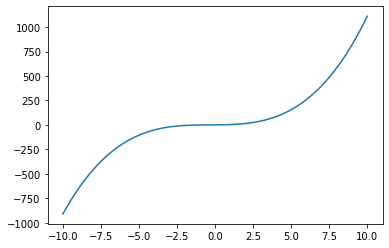

In [53]:
plot(random_polynomial)

In [47]:
def plot_grad(fn, l=-10, r=10, n=1000):

    x_array = np.linspace(l, r, num=n)

    y_array = []

    for x  in x_array:
      y_array.append(fn(x))

    plt.plot(x_array, y_array); 
    plt.show()

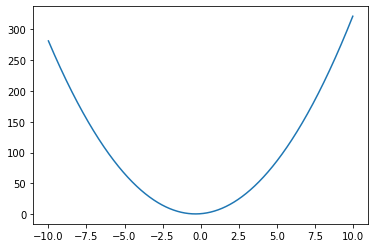

In [48]:
# 3x**2 + 2x + 1
dx_fn = grad(random_polynomial)

plot_grad(dx_fn)

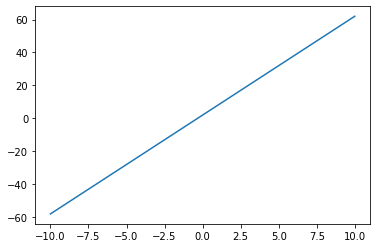

In [49]:
# 6x + 2
d2x_fn = grad(grad(random_polynomial))

plot_grad(d2x_fn)

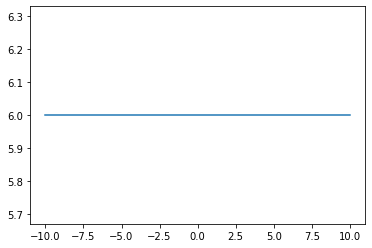

In [50]:
# 6
d3x_fn = grad(grad(grad(random_polynomial)))

plot_grad(d3x_fn)

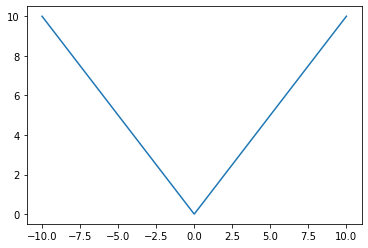

In [54]:
f = lambda x: abs(x)

plot(f)

In [59]:
f(1), f(-1)

(1, 1)

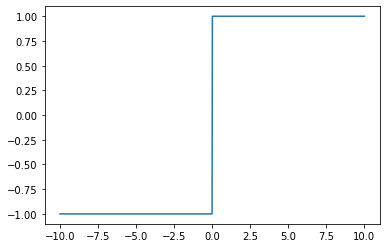

In [63]:
dfdx = grad(f)

plot_grad(dfdx)

In [64]:
dfdx(0.000001), dfdx(-0.000001)

(DeviceArray(1., dtype=float32, weak_type=True),
 DeviceArray(-1., dtype=float32, weak_type=True))

In [65]:
dfdx(0.)

DeviceArray(1., dtype=float32, weak_type=True)

# Gradients using `grad`

The `grad` function can compute gradients only on functions that operate on vectors to produce scalers

In [73]:
def f(x):
  return jnp.sum(x**2)

dfdx = grad(f)

In [76]:
dfdx(4.)

DeviceArray(8., dtype=float32, weak_type=True)

In [78]:
dfdx(jnp.array([2., 3., 4.]))

DeviceArray([4., 6., 8.], dtype=float32)

# Stopping Gradients computation

Sometimes we do not want the gradients to flow through some of the variables involved in a specific computation. In that case, we need to tell JAX explicitly that we don't want the gradients to flow through the specified set of variables.

In [66]:
x, w, b

(4.0, 3.0, 2.0)

In [67]:
def linear_func_stop_grad(x, w, b):

    y = w * jax.lax.stop_gradient(x) + b

    return y

In [68]:
dx = grad(linear_func_stop_grad, argnums = 0)(x, w, b)

dx

DeviceArray(0., dtype=float32, weak_type=True)

# Jacobian and Hessian for Vector-Valued Functions
For vector-valued functions which map vectors to vectors, the analogue to the gradient is the Jacobian. With the function transformations jacfwd() and jacrev(), corresponding to forward mode differentiation and reverse mode differentiation.

In [79]:
from jax import jacfwd

def mapping(v):
 
  x = v[0]
  y = v[1]
  z = v[2]
  return jnp.array([x*y, y*z])

In [84]:
# 3 inputs, 2 outputs

# [d/dx x*y , d/dy x*y, d/dz x*y]
# [d/dx y*z , d/dy y*z, d/dz y*z]

# [y, x, 0]
# [0, z, y]

f = jacfwd(mapping)

print(f(jnp.array([2., 3., 4.])))

[[3. 2. 0.]
 [0. 4. 3.]]


The Hessian matrix or Hessian is a square matrix of second-order partial derivatives of a scalar-valued function, or scalar field.

In [83]:
def f(x):
  return jnp.dot(x, x)

def hessian(f):
  return jacfwd(grad(f))

hessian(f)(jnp.array([1., 2., 3.]))

DeviceArray([[2., 0., 0.],
             [0., 2., 0.],
             [0., 0., 2.]], dtype=float32)